In [994]:
import numpy as np
import pandas as pd
import re
import json
import glob
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

%matplotlib inline

Downloading datasets

In [959]:
train = pd.read_csv('input/train/train.csv')
test = pd.read_csv('input/test/test.csv')
sample_submission = pd.read_csv('input/test/sample_submission.csv')

In [960]:
train.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  ...  Health  Quantity  Fee  State  \
0             1  ...       1         1  100  41326   
1             2  ...       1         1    0  41401   
2             2  ...       1         1    0  41326   
3             2  ...       1         1  150  41401   
4             2  ...       1         1    0  41326   

                          RescuerID  VideoAmt  \
0  8480853f516546f6cf33aa88cd76c379         0   
1  3082c7125d8fb66f7dd4bff4192c8b14         0   
2  fa90fa5b1ee11c86938398b60abc32cb         0   
3  9238e4f44c71a75282e62f7136c6b240         0   
4  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3      1.0   
1  I just found it alone yesterday near my apartm...  6296e909a      2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906      7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5      8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90      3.0   

   AdoptionSpeed  
0              2  
1              0  
2              3  
3              2  
4              2  

[5 rows x 24 columns]

In [961]:
test.head()

Type       Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     1      Puppy    2     307       0       1       1       0       0   
1     2     London   24     266       0       1       2       7       0   
2     2   Snowball   20     266       0       2       7       0       0   
3     2     Malibu    5     266     252       2       1       6       7   
4     1  Lala Girl    6     307       0       2       1       2       7   

   MaturitySize  ...  Sterilized  Health  Quantity  Fee  State  \
0             2  ...           2       1         1  150  41326   
1             2  ...           1       1         1    0  41326   
2             2  ...           1       1         1  150  41326   
3             2  ...           1       1         1  100  41326   
4             2  ...           1       1         1  150  41326   

                          RescuerID  VideoAmt  \
0  4475f31553f0170229455e3c5645644f         0   
1  4475f31553f0170229455e3c5645644f         0   
2  4475f31553f0170229455e3c5645644f         0   
3  4475f31553f0170229455e3c5645644f         0   
4  4475f31553f0170229455e3c5645644f         0   

                                         Description      PetID  PhotoAmt  
0  Puppy is calm for a young dog, but he becomes ...  378fcc4fc       3.0  
1  Urgently seeking adoption. Please contact for ...  73c10e136       1.0  
2  Snowball... doesn't look so good (she is healt...  72000c4c5       1.0  
3  Malibu: Female, Local Mix, 4-5 months, vaccina...  e147a4b9f       1.0  
4  LALA! That's my name. I'm a 6 month old girl d...  43fbba852       1.0  

[5 rows x 23 columns]

We see that most of information is categorical, but alreasy encoded, the description for some we can find in these files:

In [962]:
labels_breed = pd.read_csv('input/breed_labels.csv')
labels_state = pd.read_csv('input/state_labels.csv')
labels_color = pd.read_csv('input/color_labels.csv')

# Table dataset processing

Let's take a look at information:

In [963]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

In [964]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3948 entries, 0 to 3947
Data columns (total 23 columns):
Type            3948 non-null int64
Name            3645 non-null object
Age             3948 non-null int64
Breed1          3948 non-null int64
Breed2          3948 non-null int64
Gender          3948 non-null int64
Color1          3948 non-null int64
Color2          3948 non-null int64
Color3          3948 non-null int64
MaturitySize    3948 non-null int64
FurLength       3948 non-null int64
Vaccinated      3948 non-null int64
Dewormed        3948 non-null int64
Sterilized      3948 non-null int64
Health          3948 non-null int64
Quantity        3948 non-null int64
Fee             3948 non-null int64
State           3948 non-null int64
RescuerID       3948 non-null object
VideoAmt        3948 non-null int64
Description     3946 non-null object
PetID           3948 non-null object
PhotoAmt        3948 non-null float64
dtypes: float64(1), int64(18), object(4)
memory usage: 709.

In [965]:
no_name_train = int(np.sum(train.Name.isna())/len(train.Name) * 100)
no_name_test = int(np.sum(test.Name.isna())/len(test.Name) * 100)
print(f'{no_name_train}% of train and {no_name_test}% of test names are missing')

8% of train and 7% of test names are missing


Above we did not count names as 'Not yet named' etc. And for prediction names of pets are not useful, so we can drop this column.

In [966]:
train = train.drop(columns='Name')
test = test.drop(columns='Name')

We can use PetIDs as index to simplify merging of datasets:

In [967]:
train.set_index('PetID', inplace=True)
test.set_index('PetID', inplace=True)

In addition to this dataset we have two more json files with processed images and descriptions. Let's merge them together. Fow this we need to do some additional procedures.

In [656]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        self.debug = debug
        self.sentence_sep = ' '
        self.extract_sentiment_text = False
    
    def open_metadata_file(self, filename):
        with open(filename, 'r') as f:
            metadata_file = json.load(f)
        return metadata_file
            
    def open_sentiment_file(self, filename):
        with open(filename, 'r') as f:
            sentiment_file = json.load(f)
        return sentiment_file
        
    def parse_sentiment_file(self, file, pet_id):        
        file_sentiment = file['documentSentiment']
        file_sentiment = pd.DataFrame(file_sentiment,  index=[pet_id]).add_prefix('document_')

        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]
        file_sentences_sentiment = pd.DataFrame(file_sentences_sentiment).mean().to_dict()
        file_sentences_sentiment = pd.DataFrame(file_sentences_sentiment,  index=[pet_id]).add_prefix('sentences_mean_')

        file_entities_type = dict(Counter([x['type'] for x in file['entities']]))
        file_entities_type = pd.DataFrame(file_entities_type, index=[pet_id])
        df_sentiment = pd.concat([file_sentiment,file_sentences_sentiment, file_entities_type], axis=1)
        return df_sentiment
    
    def parse_metadata_file(self, file, pet_id):
        file_keys = list(file.keys())
        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations'][:3]
            file_top_score = np.array([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']

        file_crops = file['cropHintsAnnotation']['cropHints']
        file_crop_conf = np.array([x['confidence'] for x in file_crops]).mean()

        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.array([x['importanceFraction'] for x in file_crops]).mean()
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'annots_score': file_top_score,
            'crop_conf': file_crop_conf,
            'crop_importance': file_crop_importance,
            'annots_top_desc': self.sentence_sep.join(file_top_desc)
        }

        df_metadata = pd.DataFrame(df_metadata, index=[pet_id])
        for i in range(2):
            file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors'][i]
            file_color_rgb = pd.DataFrame(file_colors['color'], index=[pet_id]).add_suffix(f'_{i}')
            del file_colors['color']
            file_color_score = pd.DataFrame(file_colors, index=[pet_id]).add_suffix(f'_{i}')
            df_metadata = pd.concat([df_metadata, file_color_rgb, file_color_score], axis=1)
        df_metadata = df_metadata.add_prefix('metadata_')
        
        return df_metadata
    
def extract_additional_features(pet_id, mode='train'):
    sentiment_filename = 'input/{}_sentiment/{}.json'.format(mode, pet_id)
    try:
        sentiment_file = pet_parser.open_sentiment_file(sentiment_filename)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file, pet_id)
    except FileNotFoundError:
        df_sentiment = pd.DataFrame()

    dfs_metadata = pd.DataFrame()
    metadata_filenames = sorted(glob.glob('input/{}_metadata/{}*.json'.format(mode, pet_id)))
    
    if len(metadata_filenames)>0:
        metadata_file = pet_parser.open_metadata_file(metadata_filenames[0])
        df_metadata = pet_parser.parse_metadata_file(metadata_file, pet_id)
    else:
        df_metadata = pd.DataFrame()
    dfs = pd.concat([df_sentiment, df_metadata], axis=1)
    
    return dfs


pet_parser = PetFinderParser()

In [734]:
train_pet_ids = train.index.values

dfs_train = Parallel(n_jobs=-1, verbose=10)(
    delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 9105 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 9240 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 9377 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 9514 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 9653 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 9933 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 10074 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 10217 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 10360 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 10505 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 10650 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 10797 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 10944 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 11093 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 11242 tasks      | 

In [735]:
test_pet_ids = test.index.values

dfs_test = Parallel(n_jobs=-1, verbose=10)(
    delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1151s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 300 tas

In [736]:
add_train = pd.concat(dfs_train, axis=0)
add_test = pd.concat(dfs_test, axis=0)

In [968]:
full_train = pd.concat([train, add_train], axis=1)
full_test = pd.concat([test, add_test], axis=1)

Also there is a "Description" column, which has NaN. But it's important feature for us, so we can weplace NaN with smth, which will say that there is no description in text format. Also as feature we selected the length of the description.

In [969]:
full_train['CharCont'] = full_train['Description'].str.len()
full_test['CharCont'] = full_test['Description'].str.len()

Now we have additional datasets for train and for test. They both have NaNs and text values. To simplify our job, lets put all text values in one column. And process it together.

In [970]:
column_types = full_train.dtypes

int_cols = column_types[column_types == 'int']
float_cols = column_types[column_types == 'float']
cat_cols = column_types[column_types == 'object']

print('\tinteger columns:\n{}'.format(int_cols))
print('\n\tfloat columns:\n{}'.format(float_cols))
print('\n\tto encode columns:\n{}'.format(cat_cols))

	integer columns:
Type             int64
Age              int64
Breed1           int64
Breed2           int64
Gender           int64
Color1           int64
Color2           int64
Color3           int64
MaturitySize     int64
FurLength        int64
Vaccinated       int64
Dewormed         int64
Sterilized       int64
Health           int64
Quantity         int64
Fee              int64
State            int64
VideoAmt         int64
AdoptionSpeed    int64
dtype: object

	float columns:
PhotoAmt                    float64
CONSUMER_GOOD               float64
EVENT                       float64
LOCATION                    float64
ORGANIZATION                float64
OTHER                       float64
PERSON                      float64
WORK_OF_ART                 float64
document_magnitude          float64
document_score              float64
metadata_annots_score       float64
metadata_blue_0             float64
metadata_blue_1             float64
metadata_crop_conf          float64
metadata_c

Let's now focuse on descriptions of pets.

In [971]:
full_train['Description'] = full_train['Description'].map(str) + full_train['metadata_annots_top_desc']
full_train.drop(columns=['metadata_annots_top_desc'], inplace=True)

In [972]:
full_test['Description'] = full_test['Description'].map(str) + full_test['metadata_annots_top_desc']
full_test.drop(columns=['metadata_annots_top_desc'], inplace=True)

In [973]:
full_train['Description'].fillna('MISSING', inplace=True)
full_train.fillna(0, inplace=True)
full_test['Description'].fillna('MISSING', inplace=True)
full_test.fillna(0, inplace=True)

Now we don't have any NaN in our datasets.

In [974]:
column_types = full_train.dtypes

int_cols = column_types[column_types == 'int']
float_cols = column_types[column_types == 'float']
cat_cols = column_types[column_types == 'object']

print('\tinteger columns:\n{}'.format(int_cols))
print('\n\tfloat columns:\n{}'.format(float_cols))
print('\n\tto encode columns:\n{}'.format(cat_cols))

	integer columns:
Type             int64
Age              int64
Breed1           int64
Breed2           int64
Gender           int64
Color1           int64
Color2           int64
Color3           int64
MaturitySize     int64
FurLength        int64
Vaccinated       int64
Dewormed         int64
Sterilized       int64
Health           int64
Quantity         int64
Fee              int64
State            int64
VideoAmt         int64
AdoptionSpeed    int64
dtype: object

	float columns:
PhotoAmt                    float64
CONSUMER_GOOD               float64
EVENT                       float64
LOCATION                    float64
ORGANIZATION                float64
OTHER                       float64
PERSON                      float64
WORK_OF_ART                 float64
document_magnitude          float64
document_score              float64
metadata_annots_score       float64
metadata_blue_0             float64
metadata_blue_1             float64
metadata_crop_conf          float64
metadata_c

In [975]:
train_descr = [' '.join(s.lower().split()) for s in full_train['Description'].tolist()]
train_descr = [' '.join(re.findall('[A-Za-z]+', s)) for s in train_descr]
full_train['Description'] = train_descr

In [976]:
test_descr = [' '.join(s.lower().split()) for s in full_test['Description'].tolist()]
test_descr = [' '.join(re.findall('[A-Za-z]+', s)) for s in test_descr]
full_test['Description'] = test_descr

In [977]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
final = []
for line in (full_train['Description'].tolist()):
    tokens = word_tokenize(line)
    no_stop = [i for i in tokens if not i in stop_words]
    no_end = [stemmer.stem(i) for i in no_stop]
    final.append(' '.join(no_end))
full_train['Description'] = final

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yagafarova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [978]:
final = []
for line in (full_test['Description'].tolist()):
    tokens = word_tokenize(line)
    no_stop = [i for i in tokens if not i in stop_words]
    no_end = [stemmer.stem(i) for i in no_stop]
    final.append(' '.join(no_end))
full_test['Description'] = final

In [980]:
vect = TfidfVectorizer(min_df=0.1, ngram_range=(1,2),
                             analyzer='word', stop_words ='english')

vec_train = vect.fit_transform(full_train['Description'])
vec_test = vect.transform(full_test['Description'])

In [981]:
vec_train = pd.DataFrame(vec_train.todense(), index=full_train.index).add_prefix('tfidf_')
vec_test = pd.DataFrame(vec_test.todense(), index=full_test.index).add_prefix('tfidf_')

In [982]:
full_train.drop(columns='Description', inplace=True)
full_test.drop(columns='Description', inplace=True)

In [983]:
full_train = pd.concat([full_train,vec_train], axis=1)
full_test = pd.concat([full_test,vec_test], axis=1)

In [986]:
column_types = full_train.dtypes

int_cols = column_types[column_types == 'int']
float_cols = column_types[column_types == 'float']
cat_cols = column_types[column_types == 'object']

print('\tinteger columns:\n{}'.format(int_cols))
print('\n\tfloat columns:\n{}'.format(float_cols))
print('\n\tto encode columns:\n{}'.format(cat_cols))

	integer columns:
Type             int64
Age              int64
Breed1           int64
Breed2           int64
Gender           int64
Color1           int64
Color2           int64
Color3           int64
MaturitySize     int64
FurLength        int64
Vaccinated       int64
Dewormed         int64
Sterilized       int64
Health           int64
Quantity         int64
Fee              int64
State            int64
VideoAmt         int64
AdoptionSpeed    int64
dtype: object

	float columns:
PhotoAmt                    float64
CONSUMER_GOOD               float64
EVENT                       float64
LOCATION                    float64
ORGANIZATION                float64
OTHER                       float64
PERSON                      float64
WORK_OF_ART                 float64
document_magnitude          float64
document_score              float64
metadata_annots_score       float64
metadata_blue_0             float64
metadata_blue_1             float64
metadata_crop_conf          float64
metadata_c

In [998]:
enc = TargetEncoder()
encode_train = enc.fit_transform(full_train['RescuerID'].tolist(), full_train['AdoptionSpeed'].tolist())
encode_test = enc.transform(full_test['RescuerID'].tolist())

In [1014]:
full_train['RescuerID'] = encode_train.values
full_test['RescuerID'] = encode_test.values

In [1016]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14993 entries, 0008c5398 to fffd9b5a8
Data columns (total 98 columns):
Type                        14993 non-null int64
Age                         14993 non-null int64
Breed1                      14993 non-null int64
Breed2                      14993 non-null int64
Gender                      14993 non-null int64
Color1                      14993 non-null int64
Color2                      14993 non-null int64
Color3                      14993 non-null int64
MaturitySize                14993 non-null int64
FurLength                   14993 non-null int64
Vaccinated                  14993 non-null int64
Dewormed                    14993 non-null int64
Sterilized                  14993 non-null int64
Health                      14993 non-null int64
Quantity                    14993 non-null int64
Fee                         14993 non-null int64
State                       14993 non-null int64
RescuerID                   14993 non-null float64


In [1047]:
X_train = full_train.drop(columns=['AdoptionSpeed'])
y_train = full_train['AdoptionSpeed']
X_test = full_test.copy()

### model training:

In competition we need to use quadratic weighted kappa. For this we took a Python code from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py

In [1049]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

In [1075]:
from __future__ import print_function
import codecs
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import itertools
from uuid import uuid4
from sklearn.model_selection import train_test_split

N_HYPEROPT_PROBES = 500
EARLY_STOPPING = 500
HYPEROPT_ALGO = tpe.suggest  #  tpe.suggest OR hyperopt.rand.suggest
NB_CV_FOLDS = 3

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, 
                                            test_size=0.1, random_state=42, shuffle=True)

D_train = lgb.Dataset(X_tr, y_tr)
D_val = lgb.Dataset(X_val, y_val)

def get_lgb_params(space):
    lgb_params = dict()
    lgb_params['boosting_type'] = space['boosting_type'] if 'boosting_type' in space else 'gbdt'
    lgb_params['application'] = 'multiclass'
    lgb_params['metric'] = ''
    lgb_params['num_class'] = 5
    lgb_params['learning_rate'] = space['learning_rate']
    lgb_params['num_leaves'] = int(space['num_leaves'])
    lgb_params['min_data_in_leaf'] = int(space['min_data_in_leaf'])
    lgb_params['min_sum_hessian_in_leaf'] = space['min_sum_hessian_in_leaf']
    lgb_params['max_depth'] = -1
    lgb_params['lambda_l1'] = space['lambda_l1'] if 'lambda_l1' in space else 0.0
    lgb_params['lambda_l2'] = space['lambda_l2'] if 'lambda_l2' in space else 0.0
    lgb_params['max_bin'] = int(space['max_bin']) if 'max_bin' in space else 256
    lgb_params['feature_fraction'] = space['feature_fraction']
    lgb_params['bagging_fraction'] = space['bagging_fraction']
    lgb_params['bagging_freq'] = int(space['bagging_freq']) if 'bagging_freq' in space else 1

    return lgb_params

obj_call_count = 0
cur_best_loss = np.inf
log_writer = open( 'lgb-hyperopt-log.txt', 'w' )

def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nLGB objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    lgb_params = get_lgb_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = lgb.train(lgb_params,
                           D_train,
                           num_boost_round=500,
                           # metrics='mlogloss',
                           valid_sets=D_val,
                           # valid_names='val',
                           # fobj=None,
                           feval = quadratic_weighted_kappa,
                           # init_model=None,
                           # feature_name='auto',
                           # categorical_feature='auto',
                           early_stopping_rounds=100,
                           # evals_result=None,
                           verbose_eval=False,
                           # learning_rates=None,
                           # keep_training_booster=False,
                           # callbacks=None
                           )

    nb_trees = model.best_iteration
    val_loss = model.best_score

    print('nb_trees={} val_loss={}'.format(nb_trees, val_loss))

    y_pred = model.predict(X_test, num_iteration=nb_trees)
    test_loss = sklearn.metrics.log_loss(y_test, y_pred, labels=list(range(10)))
    acc = sklearn.metrics.accuracy_score(y_test, numpy.argmax(y_pred, axis=1))
    print('test_loss={} test_acc={}'.format(test_loss, acc))

    log_writer.write('loss={:<7.5f} acc={} Params:{} nb_trees={}\n'.format(test_loss, acc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

space ={
        'num_leaves': hp.quniform ('num_leaves', 10, 200, 1),
        'min_data_in_leaf':  hp.quniform ('min_data_in_leaf', 10, 200, 1),
        'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2.3),
        'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', 0, 2.3),
        'max_bin': hp.quniform ('max_bin', 64, 512, 1),
        'bagging_freq': hp.quniform ('bagging_freq', 1, 5, 1),
        'lambda_l1': hp.uniform('lambda_l1', 0, 10 ),
        'lambda_l2': hp.uniform('lambda_l2', 0, 10 ),
       }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=1)

print('-'*50)
print('The best params:')
print( best )
print('\n\n')

                                                     
LGB objective call #1 cur_best_loss=    inf
Params: bagging_fraction=0.9635947428859852 bagging_freq=3.0 feature_fraction=0.8729145695754188 lambda_l1=3.7793909885137955 lambda_l2=5.05862869542398 learning_rate=0.020947810861273765 max_bin=354.0 min_data_in_leaf=121.0 min_sum_hessian_in_leaf=2.6449982654650017 num_leaves=181.0
  0%|          | 0/500 [00:00<?, ?it/s, best loss: ?]


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Dataset'

In [1080]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [1083]:
### import lightgbm as lgb

params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17}

# Additional parameters:
early_stop = 100
verbose_eval = 100
num_rounds = 10000
n_splits = 3

In [1084]:
from sklearn.model_selection import KFold


kfold = KFold(n_splits=n_splits, random_state=42, shuffle=True)


oof_train = np.zeros((X_train.shape[0]))
oof_test = np.zeros((X_test.shape[0], n_splits))


i = 0
for train_index, valid_index in kfold.split(X_train, y_train):
    
    X_tr = X_train.iloc[train_index]
    X_val = X_train.iloc[valid_index]
    
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]
    
    print('\ny_tr distribution: {}'.format(Counter(y_tr)))
    
    d_train = lgb.Dataset(X_tr, label=y_tr)
    d_valid = lgb.Dataset(X_val, label=y_val)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    oof_train[valid_index] = val_pred
    oof_test[:, i] = test_pred
    
    i += 1


y_tr distribution: Counter({4: 2786, 2: 2713, 3: 2179, 1: 2060, 0: 257})
training LGB:
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.957626	valid_1's rmse: 0.989856
[200]	training's rmse: 0.888473	valid_1's rmse: 0.942866
[300]	training's rmse: 0.856944	valid_1's rmse: 0.930371
[400]	training's rmse: 0.836921	valid_1's rmse: 0.926934
[500]	training's rmse: 0.821814	valid_1's rmse: 0.926273
[600]	training's rmse: 0.808668	valid_1's rmse: 0.926259
[700]	training's rmse: 0.79727	valid_1's rmse: 0.926355
Early stopping, best iteration is:
[639]	training's rmse: 0.80434	valid_1's rmse: 0.926182

y_tr distribution: Counter({4: 2794, 2: 2707, 3: 2169, 1: 2052, 0: 273})
training LGB:
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.957608	valid_1's rmse: 0.988208
[200]	training's rmse: 0.888244	valid_1's rmse: 0.943231
[300]	training's rmse: 0.85662	valid_1's rmse: 0.931407
[400]	training's rmse: 0.837158	valid_1

(array([  68.,  371.,  786., 1923., 3150., 3230., 2428., 1616., 1008.,
         413.]),
 array([0.3525808 , 0.74983201, 1.14708323, 1.54433445, 1.94158566,
        2.33883688, 2.7360881 , 3.13333932, 3.53059053, 3.92784175,
        4.32509297]),
 <a list of 10 Patch objects>)

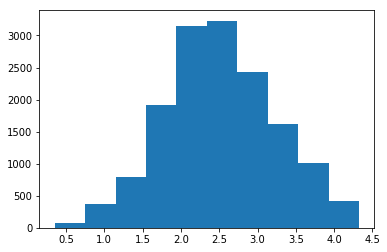

In [1085]:
plt.hist(oof_train)

In [1086]:
# Compute QWK based on OOF train predictions:
optR = OptimizedRounder()
optR.fit(oof_train, y_train)
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(y_train.values))
print("Predicted Counts = ", Counter(pred_test_y_k))
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(y_train.values, pred_test_y_k)
print("QWK = ", qwk)


Valid Counts =  Counter({4: 4197, 2: 4037, 3: 3259, 1: 3090, 0: 410})
Predicted Counts =  Counter({2.0: 4668, 3.0: 4051, 4.0: 3172, 1.0: 3092, 0.0: 10})
Coefficients =  [0.5644161  1.93557561 2.51335359 3.10818936]
QWK =  0.5817971069341115


In [1087]:
# Manually adjusted coefficients:

coefficients_ = coefficients.copy()

coefficients_[0] = 1.645
coefficients_[1] = 2.115
coefficients_[3] = 2.84

train_predictions = optR.predict(oof_train, coefficients_).astype(int)
print('train pred distribution: {}'.format(Counter(train_predictions)))

test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_)
print('test pred distribution: {}'.format(Counter(test_predictions)))

train pred distribution: Counter({4: 4778, 2: 3360, 1: 2834, 3: 2445, 0: 1576})
test pred distribution: Counter({4.0: 1520, 2.0: 1084, 3.0: 1069, 1.0: 273, 0.0: 2})


In [1088]:
# Distribution inspection of original target and predicted train and test:

print("True Distribution:")
print(pd.value_counts(y_train, normalize=True).sort_index())
print("\nTrain Predicted Distribution:")
print(pd.value_counts(train_predictions, normalize=True).sort_index())
print("\nTest Predicted Distribution:")
print(pd.value_counts(test_predictions, normalize=True).sort_index())

True Distribution:
0    0.027346
1    0.206096
2    0.269259
3    0.217368
4    0.279931
Name: AdoptionSpeed, dtype: float64

Train Predicted Distribution:
0    0.105116
1    0.189022
2    0.224105
3    0.163076
4    0.318682
dtype: float64

Test Predicted Distribution:
0.0    0.000507
1.0    0.069149
2.0    0.274569
3.0    0.270770
4.0    0.385005
dtype: float64


In [1092]:
# Generate submission:

submission = pd.DataFrame({'PetID': X_test.index, 'AdoptionSpeed': test_predictions.astype(np.int32)})
submission.head()
submission.to_csv('submission.csv', index=False)